Loads the QuickDraw dataset. Demonstrates reading the original files, working with the data as a sequence of strokes, and converting those strokes to images. Also writes a dataset to disk in a convenient format.

In [0]:
from __future__ import print_function

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import functools, itertools, json, os, re, textwrap
import tensorflow as tf

from PIL import Image, ImageDraw
from six.moves.urllib import request
from xml.dom import minidom

# Get the data

In [2]:
# Retrieve list of classes.

def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
print('available: (%d)' % len(all_ndjsons))
print('\n'.join(textwrap.wrap(
    ' '.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
    width=100)))

available: (309)
The Eiffel Tower The Great Wall of China The Mona Lisa aircraft carrier airplane alarm clock
ambulance angel animal migration ant anvil apple arm asparagus axe backpack banana bandage barn
baseball bat baseball basket basketball bat bathtub beach bear beard bed bee belt bench bicycle
binoculars bird birthday cake blackberry blueberry book boomerang bottlecap bowtie bracelet brain
bread bridge broccoli broom bucket bulldozer bus bush butterfly cactus cake calculator calendar
camel camera camouflage campfire candle cannon canoe car carrot castle cat ceiling fan cell phone
cello chair chandelier church circle clarinet clock cloud coffee cup compass computer cookie cooler
couch cow crab crayon crocodile crown cruise ship cup diamond dishwasher diving board dog dolphin
donut door dragon dresser drill drums duck dumbbell ear elbow elephant envelope eraser eye
eyeglasses face fan feather fence finger fire hydrant fireplace firetruck fish flamingo flashlight
flip flops floor l

In [0]:
# Store all data locally in this directory.
data_path = 'data'
if not os.path.exists(data_path): 
  os.mkdir(data_path)

# Mini group of two animals.
pets = ['cat', 'dog']

# Somewhat larger group of zoo animals.
zoo = ['elephant', 'giraffe', 'kangaroo', 'lion', 'monkey', 'panda',
       'penguin', 'rhinoceros', 'tiger', 'zebra']

# Even larger group of all animals.
animals = ['bat', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab',
           'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 'fish',
           'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl',
           'panda', 'parrot', 'penguin', 'pig', 'rabbit', 'raccoon',
           'rhinoceros', 'scorpion', 'sea turtle', 'shark', 'sheep',
           'snail', 'spider', 'squirrel', 'teddy-bear', 'tiger',
           'whale', 'zebra']

# Create your own group -- the more classes you include the more challenging
# the classification task will be...

# Choose one of the above groups.
# Note: This will result in ~100MB of download per class.
# classes, classes_name = zoo, 'zoo'

In [0]:
animals = ['bat', 'butterfly', 'camel', 'cat', 'cow', 'crab', 'panda',
           'crocodile', 'zebra', 'dolphin', 'duck', 'elephant', 'fish',
           'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl']
classes, classes_name = animals, 'animals'

In [5]:
# Download the chosen group.

def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except (ValueError, IOError):
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

print('\n%d classes:' % len(classes))

for name in classes:
    print(name, end=' ')
    dst = '%s/%s.ndjson' % (data_path, name)
    retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
    print('%.2f MB' % (os.path.getsize(dst) / 2.**20))

print('\nDONE :)')



25 classes:
bat 58.02 MB
butterfly 63.27 MB
camel 54.31 MB
cat 73.12 MB
cow 91.94 MB
crab 76.46 MB
panda 97.04 MB
crocodile 57.19 MB
zebra 92.10 MB
dolphin 46.29 MB
duck 67.93 MB
elephant 70.86 MB
fish 48.59 MB
frog 92.50 MB
giraffe 58.27 MB
hedgehog 90.76 MB
horse 99.79 MB
kangaroo 96.06 MB
lion 90.47 MB
lobster 86.65 MB
monkey 91.05 MB
mosquito 64.99 MB
mouse 76.35 MB
octopus 79.30 MB
owl 108.10 MB

DONE :)


# Inspect the data

In [6]:
# So let's check out the downloaded files...
!ls -lh $data_path

total 1.9G
-rw-r--r-- 1 root root  59M Nov  7 20:50 bat.ndjson
-rw-r--r-- 1 root root  64M Nov  7 20:50 butterfly.ndjson
-rw-r--r-- 1 root root  55M Nov  7 20:50 camel.ndjson
-rw-r--r-- 1 root root  74M Nov  7 20:50 cat.ndjson
-rw-r--r-- 1 root root  92M Nov  7 20:50 cow.ndjson
-rw-r--r-- 1 root root  77M Nov  7 20:50 crab.ndjson
-rw-r--r-- 1 root root  58M Nov  7 20:50 crocodile.ndjson
-rw-r--r-- 1 root root  47M Nov  7 20:50 dolphin.ndjson
-rw-r--r-- 1 root root  68M Nov  7 20:50 duck.ndjson
-rw-r--r-- 1 root root  71M Nov  7 20:50 elephant.ndjson
-rw-r--r-- 1 root root  49M Nov  7 20:51 fish.ndjson
-rw-r--r-- 1 root root  93M Nov  7 20:51 frog.ndjson
-rw-r--r-- 1 root root  59M Nov  7 20:51 giraffe.ndjson
-rw-r--r-- 1 root root  91M Nov  7 20:51 hedgehog.ndjson
-rw-r--r-- 1 root root 100M Nov  7 20:51 horse.ndjson
-rw-r--r-- 1 root root  97M Nov  7 20:51 kangaroo.ndjson
-rw-r--r-- 1 root root  91M Nov  7 20:51 lion.ndjson
-rw-r--r-- 1 root root  87M Nov  7 20:51 lobster.ndjson
-rw-r

In [7]:
# What is the NDJSON file format?
# Seems to be one JSON dictionary per line...
path = sorted(tf.gfile.Glob(os.path.join(data_path, '*.ndjson')))[1]
print(open(path).read()[:1000] + '...')

{"word":"butterfly","countrycode":"GB","timestamp":"2017-03-09 14:21:20.91043 UTC","recognized":true,"key_id":"4817223078117376","drawing":[[[114,97,74,54,35,17,7,1,0,4,21,47,40,20,13,13,18,47,77,98,128,137,126,122,124,130,136,159,166,168,164,153,147,135],[100,69,52,47,46,53,64,75,96,109,126,141,141,157,170,181,189,209,224,229,229,225,176,85,61,56,57,68,78,206,226,241,241,220]],[[172,184,212,229,247,255,254,243,225,243,247,254,254,244,217,179,154],[100,78,56,60,71,91,115,141,157,157,159,180,200,217,222,224,216]],[[129,121,90],[55,37,0]]]}
{"word":"butterfly","countrycode":"RU","timestamp":"2017-03-01 16:39:32.90537 UTC","recognized":true,"key_id":"6574914117042176","drawing":[[[8,1,4,0,15,23,33,62,73,84,85,75,61,11],[40,65,156,190,243,253,253,233,220,194,153,104,62,37]],[[69,79,91,116,130,144,170,193,204,205,202,194,183,168,193,202,214,223,222,209,192,170,149,119,97,86],[88,75,40,9,2,0,3,22,53,69,84,96,105,110,110,113,126,156,172,194,208,219,224,225,212,196]]]}
{"word":"butterfly","cou

In [8]:
# Parse single line.
data_json = json.loads(open(path).readline())
data_json.keys()

[u'word', u'countrycode', u'timestamp', u'recognized', u'key_id', u'drawing']

In [9]:
# So we have some meta information...
for k, v in data_json.items():
    if k != 'drawing':
        print('%20s   ->   %s' % (k, v))

                word   ->   butterfly
         countrycode   ->   GB
           timestamp   ->   2017-03-09 14:21:20.91043 UTC
          recognized   ->   True
              key_id   ->   4817223078117376


In [10]:
# ...and the actual drawing.
drawing = data_json['drawing']
# The drawing consists of a series of strokes:
[np.array(stroke).shape for stroke in drawing]

[(2, 34), (2, 17), (2, 3)]

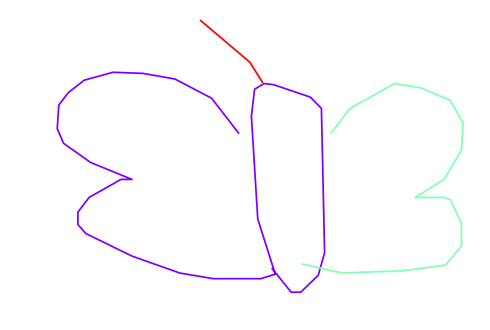

In [11]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:

def draw_strokes(drawing):
  # Use a different color for each stroke
  colors = cm.rainbow(np.linspace(0, 1, len(drawing)))
  plt.axis('off')
  for stroke, c in zip(drawing, colors):
    #print(stroke[0], stroke[1])
    plt.plot(np.array(stroke[0]), -1 * np.array(stroke[1]), color=c)
    
draw_strokes(drawing)

In [12]:
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

print('loading some "%s"...' % classes[0])
sample = loadn(classes[0], 100)

loading some "bat"...


In [13]:
sample[0]

{u'countrycode': u'RO',
 u'drawing': [array([[111,  89,  79,  77,  82,  89, 103, 113, 126, 125, 104],
         [ 53, 106, 147, 174, 179, 180, 172, 156, 114,  54,  55]]),
  array([[103, 103, 111, 126, 137, 137, 127],
         [ 53,  17,   1,   2,  14,  25,  44]]),
  array([[113,  98,  45,  41,  40,  45,  27,  22,  21,  25,  20,   2,   0,
            8,  42,  61,  73],
         [ 55,  48,  12,  10,  13,  53,  54,  61,  93, 125, 126, 115, 123,
          136, 165, 167, 158]]),
  array([[132, 143, 158, 171, 208, 215, 219, 248, 251, 255, 254, 242, 227,
          233, 233, 222, 211, 187, 144, 125, 111, 107],
         [ 61,  56,  37,  26,  12,  65,  67,  65,  67,  82, 102, 130, 153,
          156, 160, 173, 180, 188, 189, 189, 186, 181]])],
 u'key_id': u'5073402912047104',
 u'recognized': True,
 u'timestamp': u'2017-03-07 14:44:14.70063 UTC',
 u'word': u'bat'}

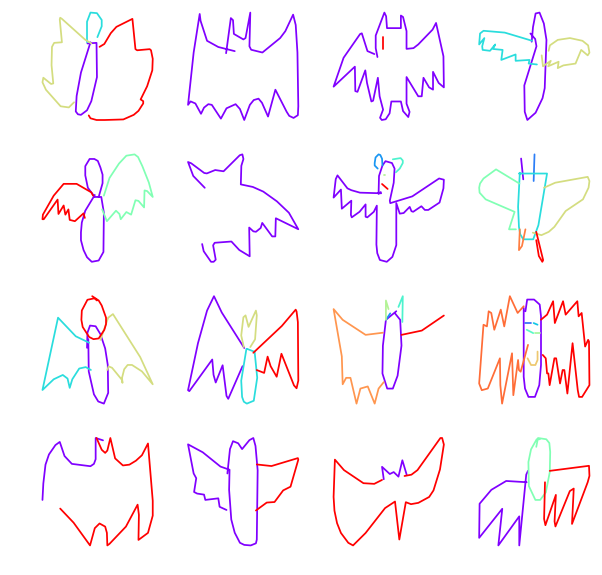

In [14]:
# Some more drawings...
plt.figure(figsize=(10, 10))
n = 4
for x in range(n):
    for y in range(n):
        i = x * n + y
        plt.subplot(n, n, i + 1)
        drawing = sample[i]['drawing']
        draw_strokes(drawing)
        
# Bats!

In [15]:
# Let's first check how many [recognized=True] examples we have in each class.
# Depending on your choice of classes you could generate >200k examples / class...
for name in classes:
    print(name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

bat 118114 recognized 96152
butterfly 117999 recognized 114549
camel 121399 recognized 115454
cat 123202 recognized 103031
cow 123083 recognized 101099
crab 126930 recognized 106466
panda 113613 recognized 94814
crocodile 127932 recognized 106410
zebra 144608 recognized 127159
dolphin 121613 recognized 110335
duck 135480 recognized 113764
elephant 126969 recognized 104986
fish 134150 recognized 126420
frog 159047 recognized 145286
giraffe 127182 recognized 122396
hedgehog 120527 recognized 103226
horse 178286 recognized 156302
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
lobster 140175 recognized 118228
monkey 127633 recognized 105650
mosquito 123029 recognized 116609
mouse 178826 recognized 166197
octopus 150152 recognized 143558
owl 169632 recognized 147654


In [32]:
num_classes=len(classes)
num_classes

25

# Strokes -> Pictures

In [0]:
# The sequence information is important! But... for now we'll 
# convert these sequences to plain old images.

In [0]:
def json_to_img(drawing, img_sz=64, lw=3, maximize=True):
    img = Image.new('L', (img_sz, img_sz))
    draw = ImageDraw.Draw(img)
    lines = np.array([
        stroke[0:2, i:i+2]
        for stroke in drawing
        for i in range(stroke.shape[1] - 1)
    ], dtype=np.float32)
    if maximize:
        for i in range(2):
            min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
            lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
    else:
        lines /= 1024
    for line in lines:
        draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
    return img

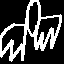

In [19]:
json_to_img(drawing)

cow


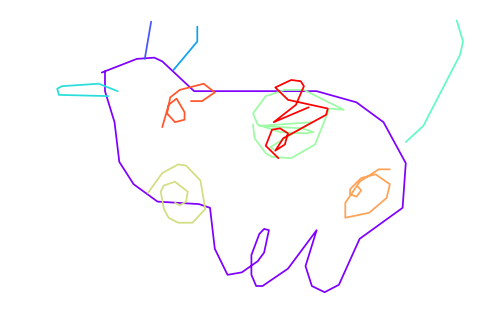

In [20]:
# Fetch some images + shuffle order.
n_per_class = 2500
drawings_matrix = [loadn(name, n_per_class) for name in classes]
drawings_list = functools.reduce(lambda x, y: x + y, drawings_matrix, [])
np.random.seed(1)
drawings_list = np.random.permutation(drawings_list)

# Quick test to see how our code works so far
draw_strokes(drawings_list[2]['drawing'])
print(str(drawings_list[2]['word']))

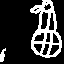

In [21]:
json_to_img(drawings_list[6]['drawing'])

# Save a dataset to disk

In [0]:
X, y = [], []
for drawing in drawings_list:
  X.append(np.array(json_to_img(drawing['drawing'])))
  y.append(str(drawing['word']))
  
dataset_path = 'mini-quickdraw.npz'
out = open(dataset_path, 'w')
np.savez_compressed(out, X, y, X=X, y=y)

In [23]:
import os
print(os.path.abspath(dataset_path))

/content/mini-quickdraw.npz


# Data Processing

In [24]:
# Demonstrate loading data
dataset_path = 'mini-quickdraw.npz'
with np.load(dataset_path) as loaded: 
    X, y = loaded["X"], loaded["y"]
print(X.shape, y.shape)

(62500, 64, 64) (62500,)


In [0]:
# 'Change the type of xs to float32'
tf.cast(X, tf.float32)
# 'Every pixel is from 0 to 255. Renormalize it to 0 and 1'
X = X/255.0 # why not 256

In [0]:
# Change y into integer
classes = list(set(y))
for i, classi in enumerate(classes):
  y[np.where(y==classi)] = i 

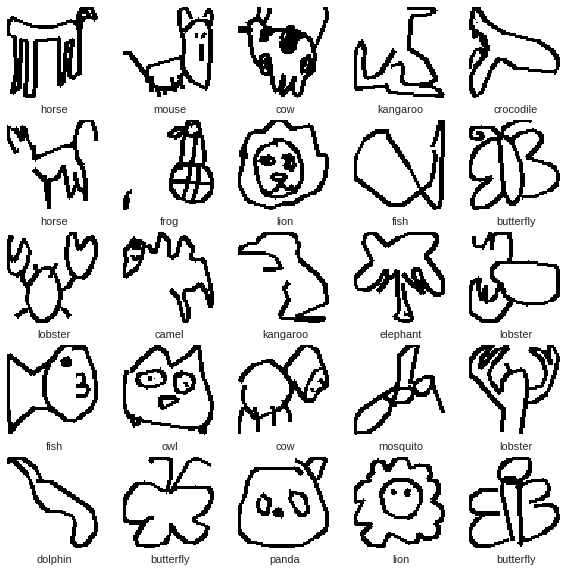

In [27]:
# explore data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.xlabel(classes[int(y[i])])
plt.show()

In [28]:
from sklearn.cross_validation import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y, test_size=0.2)
print(X_tr.shape,X_ts.shape, y_tr.shape, y_ts.shape)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(50000, 64, 64) (12500, 64, 64) (50000,) (12500,)


# A CNN Classifier

In [0]:
X_tr = np.expand_dims(X_tr,-1)
X_ts = np.expand_dims(X_ts, -1 )

In [0]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization

In [0]:
# build the model
model = tf.keras.models.Sequential()
#model.add(BatchNormalization(input_shape=X_tr.shape[1:]))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu',padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#model.add(BatchNormalization(input_shape=X_tr.shape[1:]))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')) 
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
model.add(Dropout(0.25))

#model.add(BatchNormalization(input_shape=X_tr.shape[1:]))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))


In [0]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),
              metrics=['accuracy'])

# model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
patience=1, verbose=1)

In [36]:
# train the model
history = model.fit(X_tr, y_tr,
          batch_size=20,
          epochs=10,
          verbose=1,
          validation_data=(X_ts, y_ts),
          callbacks=[early_stopping])

Train on 50000 samples, validate on 12500 samples
Epoch 1/10
50000/50000 [==============================] - 29s 574us/step - loss: 1.2303 - acc: 0.6344 - val_loss: 0.9350 - val_acc: 0.7189
Epoch 2/10
50000/50000 [==============================] - 25s 497us/step - loss: 0.7668 - acc: 0.7669 - val_loss: 0.7917 - val_acc: 0.7602
Epoch 3/10
50000/50000 [==============================] - 24s 479us/step - loss: 0.6043 - acc: 0.8122 - val_loss: 0.7705 - val_acc: 0.7715
Epoch 4/10
50000/50000 [==============================] - 24s 486us/step - loss: 0.4834 - acc: 0.8475 - val_loss: 0.8075 - val_acc: 0.7714
Epoch 00004: early stopping


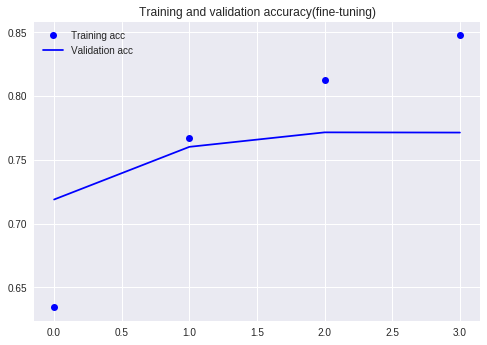

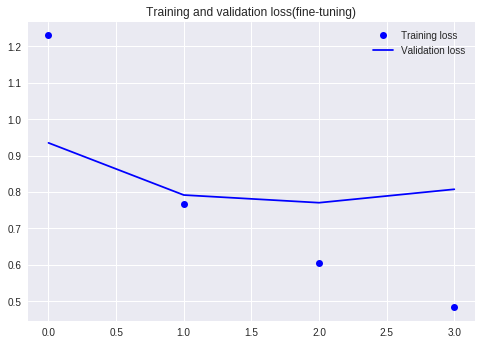

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(fine-tuning)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(fine-tuning)')
plt.legend()

plt.show()

In [38]:
score = model.evaluate(X_ts, y_ts, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

Test loss: 0.8074700082969666
Test accuracy: 0.771360000038147
